In [1]:
import matplotlib as mpl

new_rc_params = {'text.usetex': False,
                 "svg.fonttype": 'none'
                }

mpl.rcParams.update(new_rc_params)
import matplotlib.cm as cm

In [2]:
import sys, os
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

import pre_functions_clean as pf
import time_constant_shuffle_FLN as tc
import Time_Constant_Plot as TCP

In [3]:
# Read Experiment Data
filepath_lst = ['Data/Marmoset_Ji/Ji20180313S3c/',
                'Data/Marmoset_Ji/Ji20180317S3c/',
                'Data/Marmoset_Ji/Ji20180313S5c/',
                'Data/Marmoset_Ji/Ji20180308S15c/']

# filepath_lst = ['Data/Marmoset_Ji/Ji20180308S3c/',
#                 'Data/Marmoset_Ji/Ji20180313S3c/',
#                 'Data/Marmoset_Ji/Ji20180317S3c/',
#                 'Data/Marmoset_Ji/Ji20180324S3c/',
#                 'Data/Marmoset_Ji/Ji20180308S5c/',
#                 'Data/Marmoset_Ji/Ji20180313S5c/',
#                 'Data/Marmoset_Ji/Ji20180317S5c/',
#                 'Data/Marmoset_Ji/Ji20180324S5c/',
#                 'Data/Marmoset_Ji/Ji20180308S15c/',
#                 'Data/Marmoset_Ji/Ji20180313S15c/',
#                 'Data/Marmoset_Ji/Ji20180317S15c/',
#                 'Data/Marmoset_Ji/Ji20180324S15c/']

area_map_path = 'Data/Marmoset_Ji/ElectrodesIndexJi.csv'

channel_num = 96

# Ji

t_start = [17771, 9990, 11262, 22957]

# t_start = [5912, 17771, 9990, 6157,
#             6061, 11262, 5004, 7660,
#             22957, 5933, 5063, 4891]

In [4]:
# Read Model Data
MACAQUE_CASE=0
CONSENSUS_CASE=0
datafile='subgraph_data_marmoset.pkl'
p = pf.load_data(datafile)
p,W = pf.genetate_net_connectivity(p,LINEAR_HIER=0,FIT_HIER=1, IDENTICAL_HIER=0,LOCAL_IDENTICAL_HIERARCHY=0,ZERO_FLN=0,
                                   IDENTICAL_FLN=0,SHUFFLE_FLN=0,SHUFFLE_TYPE=0,STRONG_GBA=0,
                                   MACAQUE_CASE=MACAQUE_CASE,GATING_PATHWAY=0,LONGRANGE_EI_ASYMMETRY=0,CONSENSUS_CASE=CONSENSUS_CASE,
                                   diverse_hi=4)

df = pd.read_excel('Data/Marmoset_Model/Area_map_Marmoset_W.xlsx')
Area_dict = dict(zip(df['Area'], df['Region']))

AOI = ['V1', 'V2', 'V6', 'V3A', 'V4',
       'TE3', 'A47L', 'A8b']

# AOI = ['V1', 'V2', 'V6',
#        'TE3', 'A47L', 'A8b']

spine_count_AOI = [1000, 1100, 1200, 1600, 2100,
                   3100, 3600, 4900]

Initializing Model. From subgraph_data_marmoset.pkl load:
dict_keys(['fln_mat', 'sln_mat', 'hier_vals', 'areas'])
CONSENSUS_CASE=0
No STRONG GBA


In [5]:
# Compute Time constant
ind = np.arange(len(t_start))
# ind = np.arange(0, 12)
# ind = [2, 5]
filepath_lst = np.array(filepath_lst)[ind]
t_start = np.array(t_start)[ind]

psds_avg = 0
for k in range(len(filepath_lst)):
    file_path = filepath_lst[k]
    channel_all = []
    for i in range(1, channel_num+1):
        if os.path.exists(file_path+'ECoG_ch{}.mat'.format(i)):
            data_i = scipy.io.loadmat(file_path+'ECoG_ch{}.mat'.format(i))
            channel_i = data_i['ECoGData'].reshape([-1])
            channel_all.append(channel_i)
    channel_all = np.array(channel_all)

    channel_eff = channel_all[:, 2000 : int(np.floor(t_start[k]/1000)*1000)]
    # channel_eff = channel_all[:, 0 : 5000]
    
    f_axis, psds_reg = TCP.compute_psds(channel_eff, fs=1000.)
    
    psds_avg += psds_reg

psds_avg /= len(filepath_lst)

df = pd.read_csv(area_map_path)
Area = np.array(df['area_abb'])
# Area = np.delete(Area, [5,6, 7, 96, 97], axis=0)
Area_set = np.unique(Area)
area = np.array([i for i in Area_set if i in p['areas']])
region = np.array([Area_dict[i] for i in area])

tau_lst_exp = [0] * len(area)
fok_lst_exp = [0] * len(area)
for i in range(len(area)):
    psds_i = np.mean(psds_avg[Area == area[i], :], axis=0)
    tau, fok = TCP.compute_tau(f_axis, psds_i)
    tau_lst_exp[i] = tau
    fok_lst_exp[i] = fok

In [6]:
Area_set

array(['A1/2', 'A10', 'A19DI', 'A3a', 'A3b', 'A46D', 'A47L', 'A47M',
       'A4ab', 'A6DR', 'A6Va', 'A6Vb', 'A8aD', 'A8aV', 'A8b', 'A9',
       'AuA1', 'AuAL', 'AuCL', 'AuML', 'AuR', 'AuRPB', 'AuRTL', 'FST',
       'LIP', 'MIP', 'MST', 'OPt', 'PE', 'PF', 'PFG', 'PG', 'ProM', 'S2E',
       'S2PR', 'STR', 'TE1', 'TE3', 'TPO', 'TPt', 'V1', 'V2', 'V3', 'V3A',
       'V4', 'V4T', 'V5', 'V6'], dtype=object)

In [7]:
len(area)

33

In [8]:
expon_lst_exp = [0] * len(area)
for i in range(len(area)):
    expon_lst_exp[i] = fok_lst_exp[i].get_results()[0][2]

# Fig.1B Illustration of the recovery ot timescale

## An example fit of PSD

## Histogram of exponent close to 2

(1.5, 3.0)

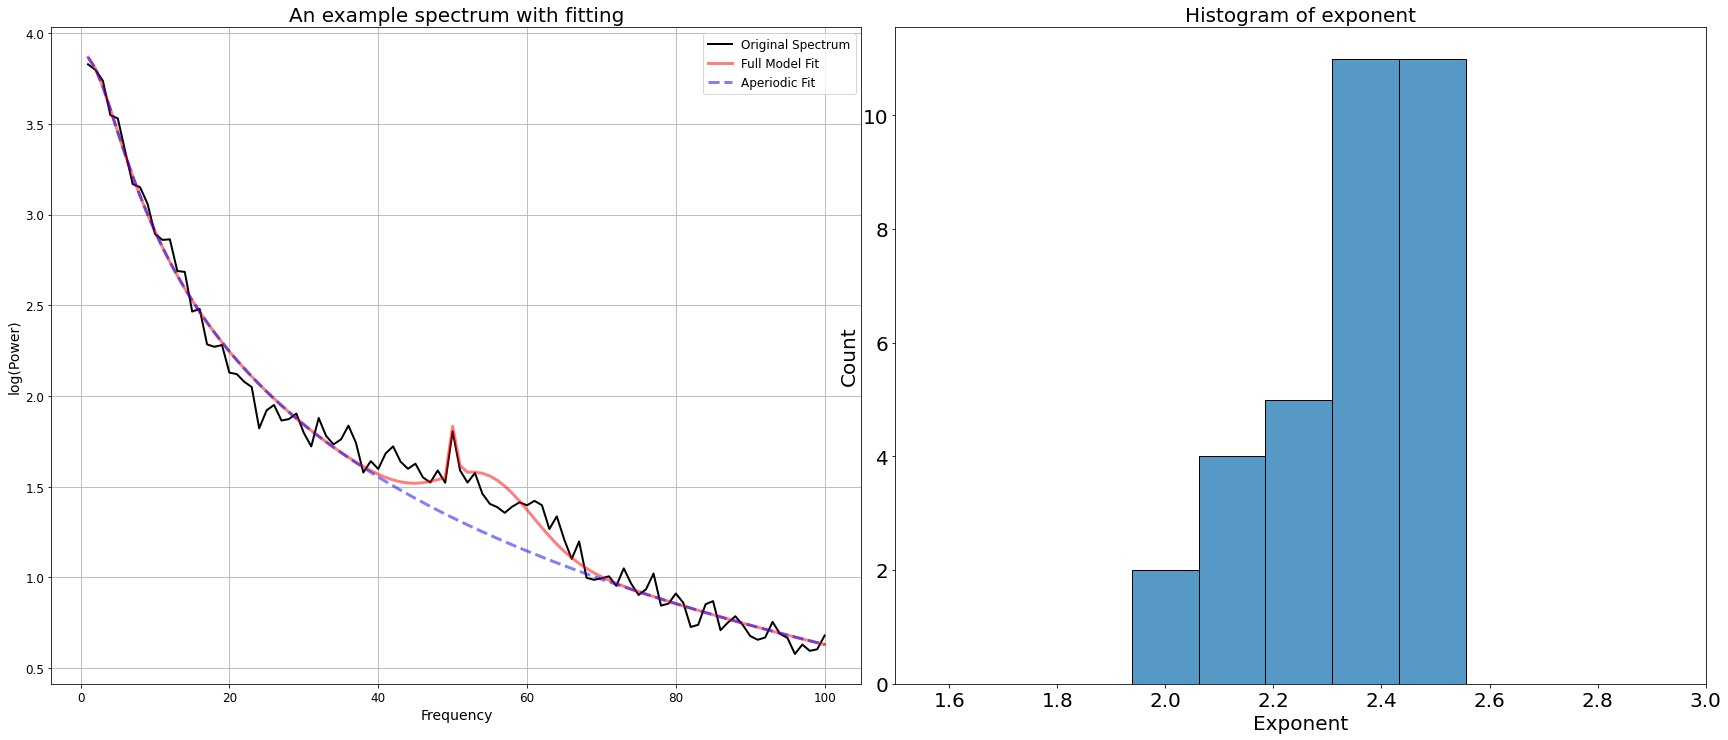

In [9]:
fig, ax = plt.subplots(1,2,figsize=(24, 10), facecolor=(1, 1, 1))

fok_lst_exp[9].plot(ax = ax[0]); # ax[0].set_xscale('log')
ax[0].set_title('An example spectrum with fitting', fontsize=20)

f1=sns.histplot(expon_lst_exp, ax=ax[1], bins=5)
ax[1].set_title('Histogram of exponent', fontsize=20)
ax[1].set_xlabel('Exponent', fontsize=20)
ax[1].set_ylabel('Count', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([1.5, 3])
# TCP.save_fig('Figures/1B')

In [10]:
# Data Alignment between Exp & Model
hi_exp = np.zeros([len(area),])
for i in range(len(area)):
    hi_exp[i] = p['hier_vals'][p['areas'].index(area[i])]
    
area_sort = []
for area_k in p['areas']:
    if area_k in area:
        area_sort.append(area_k)

# Fig.1C Visualization of the observed timescale gradient across the whole brain.

(10.0, 50.0)

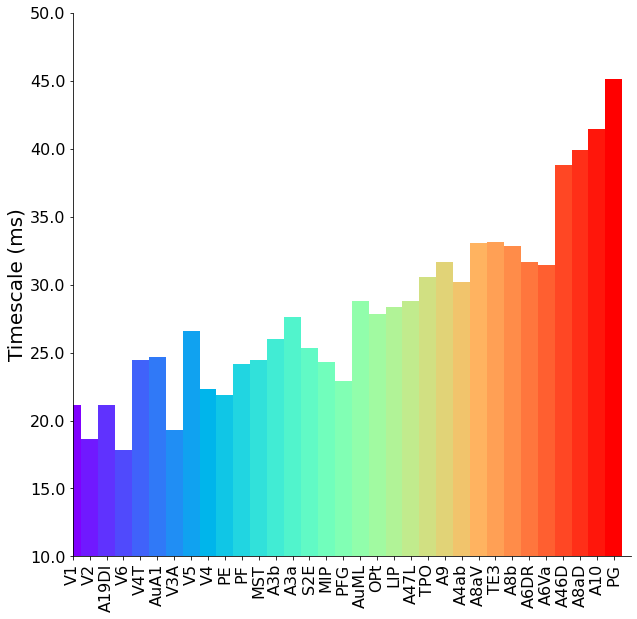

In [11]:
fig, ax=plt.subplots(figsize=(10,10), facecolor=(1, 1, 1))
clist = cm.get_cmap(plt.get_cmap('rainbow'))(np.linspace(0.0, 1.0, len(area)))[np.newaxis, :, :3]
# sort_ind = np.argsort(tau_lst_exp)
sort_ind = np.argsort(hi_exp)
area_sort = area[sort_ind]
ax.bar(np.arange(len(area)), np.array(tau_lst_exp)[sort_ind],width = 1,color=clist[0])
ax.set_xticks(np.arange(len(area)))
ax.set_yticks(np.linspace(10, 50, 9))
ax.set_yticklabels(np.linspace(10, 50, 9),fontsize=16)
ax.set_xticklabels(area_sort ,rotation=90,fontsize=16)
# plt.yticks([10,100,1000],['10 ms','100 ms','1 s'],rotation=0)
ax.set_ylabel('Timescale (ms)',fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim((0, len(area)))
ax.set_ylim((10, 50))
# TCP.save_fig('Figures/1C')

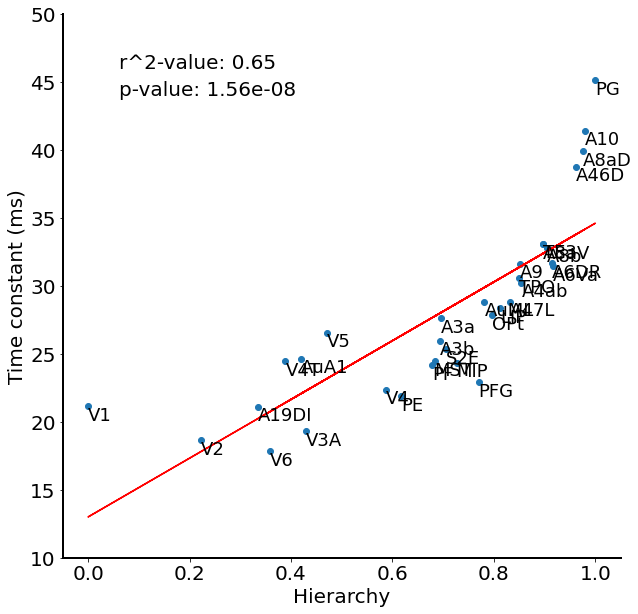

In [12]:
# Fig. Tau vs hi (experiment data)
fig = TCP.plot_tau_feature(tau_lst_exp, hi_exp, area,
        x_label='Hierarchy', y_label='Time constant (ms)',
        annotate_flag=True, log_flag=False)
fig.set_figwidth(10)
plt.ylim([10, 50])
TCP.save_fig('Figures/1C_Supp')

# Change to rainbow color bar later

# Fig.1D Demonstration of the consistency between the timescale and the structural gradient (spine count).

## Relationship with Spine count

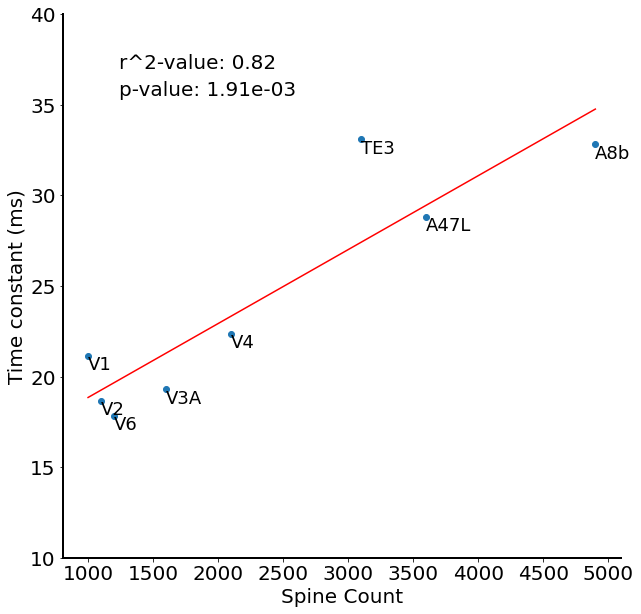

In [13]:
# Plots for AOI
tau_AOI = [0]*len(AOI)
for i in range(len(AOI)):
    tau_AOI[i] = tau_lst_exp[list(area).index(AOI[i])]
    
fig7 = TCP.plot_tau_feature(tau_AOI, spine_count_AOI, AOI,
        x_label='Spine Count', y_label='Time constant (ms)',
        annotate_flag=True, log_flag=False)
plt.ylim([10, 40])
fig7.set_figwidth(10)

# TCP.save_fig('Figures/1D')

## Region-wise timescales from experiments

[Text(0, 0, 'Visual'),
 Text(1, 0, 'Auditory'),
 Text(2, 0, 'Somatosensory'),
 Text(3, 0, 'Posterior Parietal'),
 Text(4, 0, 'liTemporal'),
 Text(5, 0, 'Motor/Premotor'),
 Text(6, 0, 'PFC')]

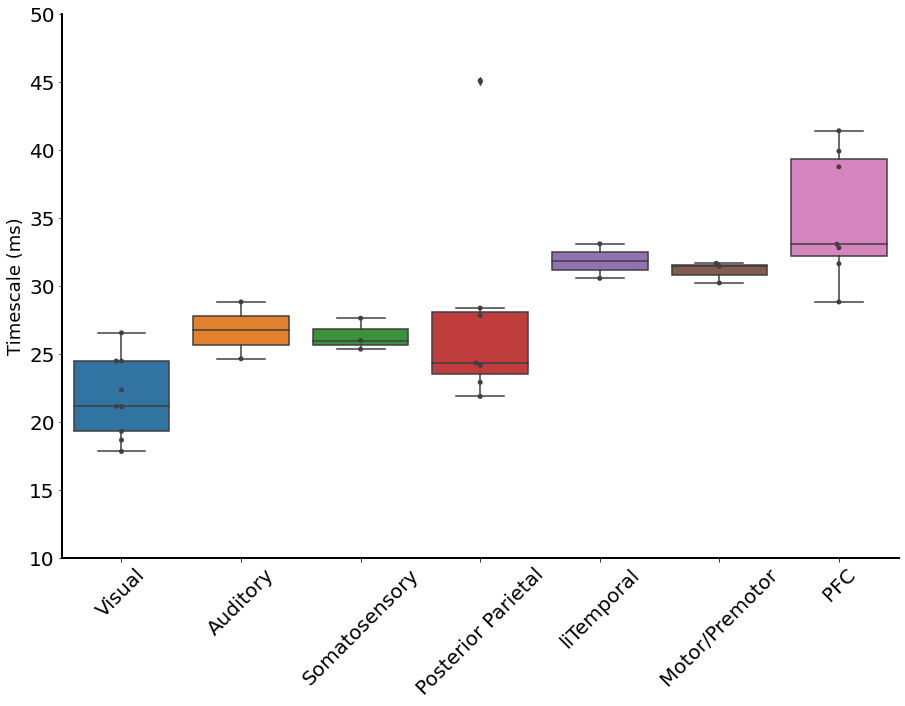

In [14]:
# hue_order = ['Visual', 'Posterior Parietal', 'liTemporal', 'Auditory', 
#        'Somatosensory', 'Motor/Premotor', 'PFC']

hue_order = ['Visual', 'Auditory', 'Somatosensory', 'Posterior Parietal', 'liTemporal',  'Motor/Premotor', 'PFC']

# region_exp = np.array(region_exp)
for area_k in ['dLPFC', 'mPFC', 'vLPFC']:
    region[region == area_k] = 'PFC'
df_exp = pd.DataFrame()
df_exp['Region'] = region
df_exp['tau'] = tau_lst_exp
fig10, ax = plt.subplots(figsize=(15,10), facecolor=(1, 1, 1))
sns.boxplot(x="Region", y="tau", data=df_exp, order=hue_order)
sns.swarmplot(x="Region", y="tau", data=df_exp, order=hue_order, color=".25")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Timescale (ms)', fontsize=18)
plt.xlabel('')
plt.ylim([10, 50])
# Hide the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Make the bottom and left spines thicker
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

ax.set_xticks(np.arange(len(hue_order)))
ax.set_xticklabels(hue_order,rotation=45,fontsize=20)

# TCP.save_fig('Figures/1D_Supp')

# Fig. 2B Plot of FLN

## Linear Scale

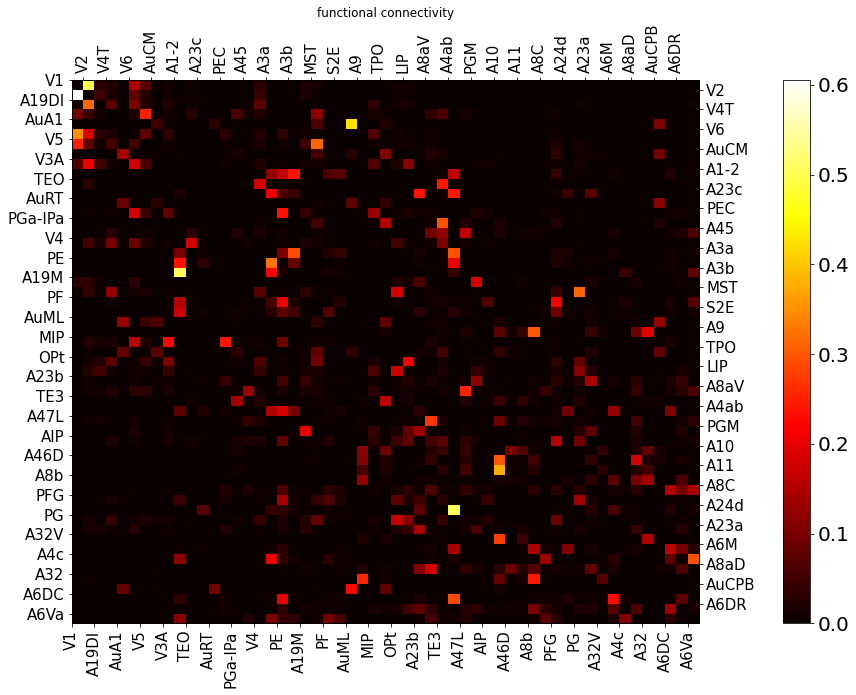

In [13]:
fig, ax = plt.subplots(1,1,figsize=(15, 10), facecolor=(1, 1, 1))
tc.plot_func_connectivity(p, p['fln_mat'].copy(), fig, ax)
TCP.save_fig('Figures/2B')

## Log Scale

In [14]:
np.min(p['fln_mat'][p['fln_mat']>0])

4.624427149086907e-06

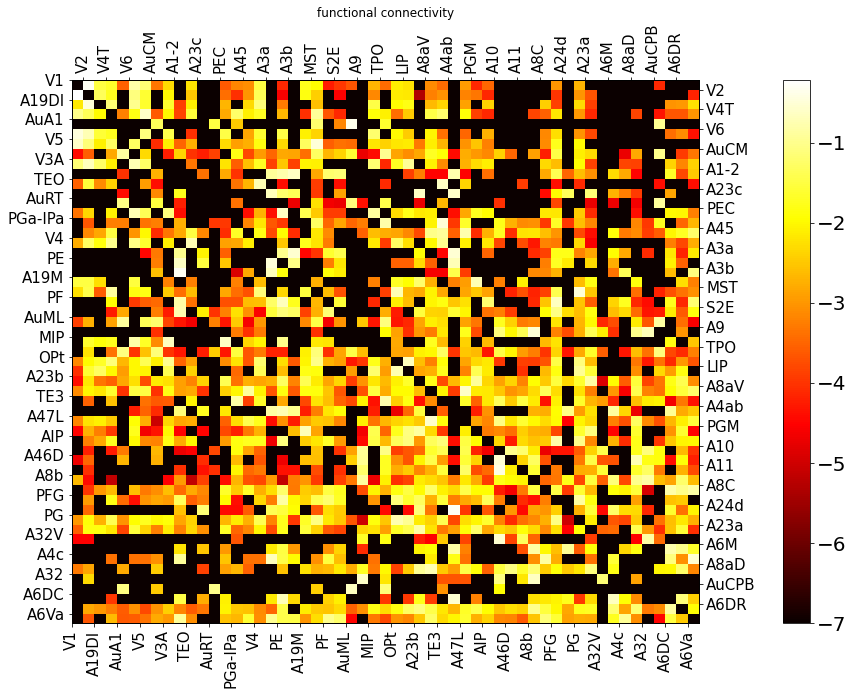

In [15]:
fig, ax = plt.subplots(1,1,figsize=(15, 10), facecolor=(1, 1, 1))
tc.plot_func_connectivity(p, np.log10(p['fln_mat'].copy() + 1e-7), fig, ax)
TCP.save_fig('Figures/2B_Supp')

# Fig. 2D Demonstration of the local gradient

## Barplot of gradients (maybe sorted version?)

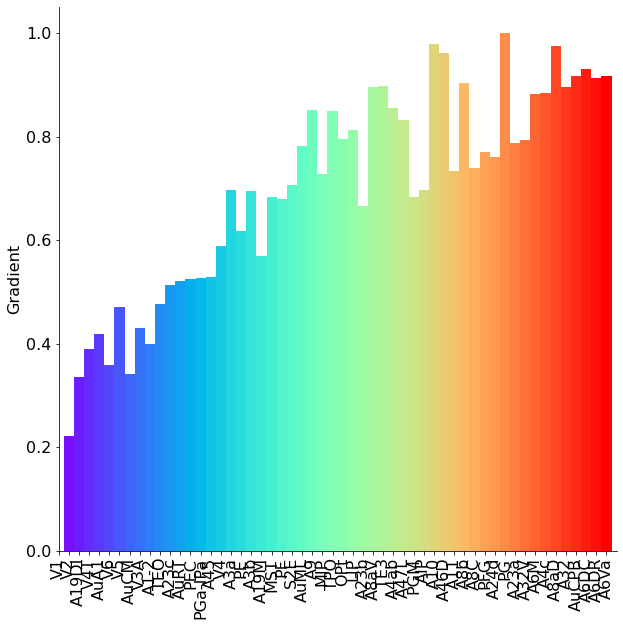

In [21]:
import matplotlib.cm as cm
# fig = TCP.plot_tau_feature(p['hier_vals'], np.arange(p['n_area']), p['areas'],
#         x_label='Area Index', y_label='Gradient',
#         annotate_flag=True, log_flag=False)
fig, ax=plt.subplots(figsize=(10, 10), facecolor=(1, 1, 1))
clist = cm.get_cmap(plt.get_cmap('rainbow'))(np.linspace(0.0, 1.0, p['n_area']))[np.newaxis, :, :3]
ax.bar(np.arange(p['n_area']),p['hier_vals'],width = 1,color=clist[0])
ax.set_xticks(np.arange(len(p['areas'])))
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0],fontsize=16)
ax.set_xticklabels(p['areas'],rotation=90,fontsize=16)
# plt.yticks([10,100,1000],['10 ms','100 ms','1 s'],rotation=0)
ax.set_ylabel('Gradient',fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim((0, p['n_area']))
TCP.save_fig('Figures/2D_a')

## Relationship with experiment data (spine count)

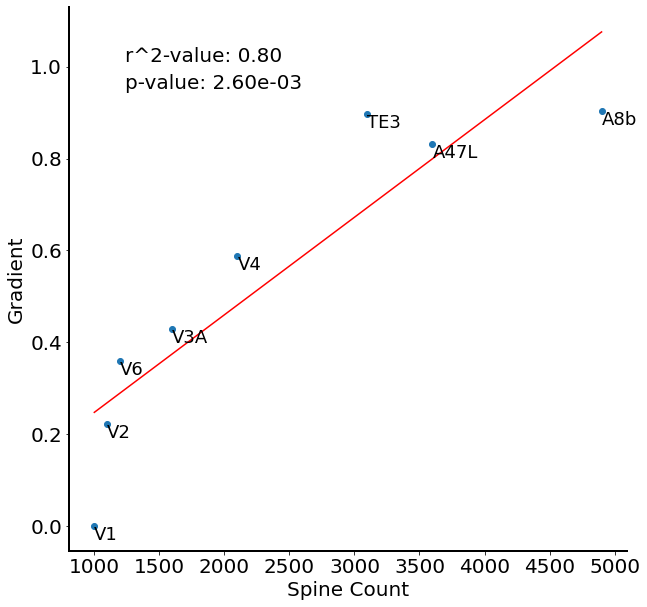

In [14]:
# Plots for AOI
hi_AOI = [0]*len(AOI)
for i in range(len(AOI)):
    hi_AOI[i] = p['hier_vals'][list(p['areas']).index(AOI[i])]
    
fig = TCP.plot_tau_feature(hi_AOI, spine_count_AOI, AOI,
        x_label='Spine Count', y_label='Gradient',
        annotate_flag=True, log_flag=False)
fig.set_figwidth(10)
fig.set_figheight(10)
TCP.save_fig('Figures/2D_b')

## Region-wise gradients in the model

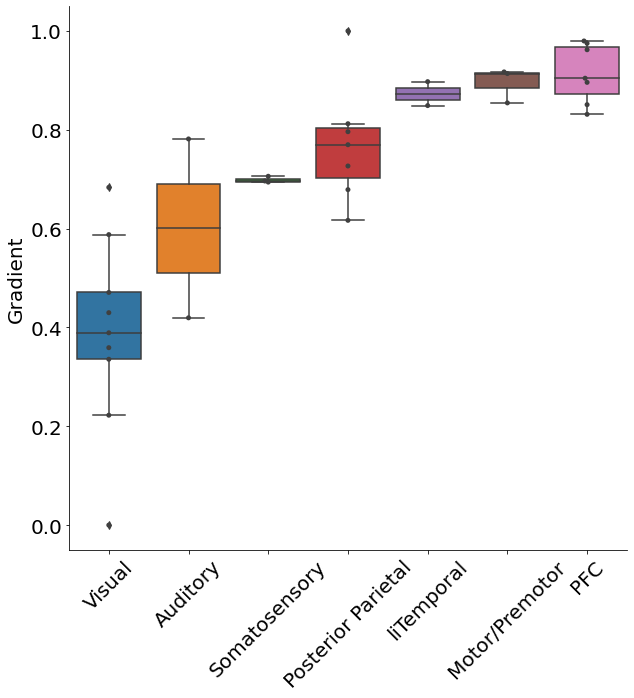

In [15]:
# hue_order = ['Visual', 'Posterior Parietal', 'liTemporal', 'Auditory', 
#        'Somatosensory', 'Motor/Premotor', 'PFC']

hue_order = ['Visual', 'Auditory', 'Somatosensory', 'Posterior Parietal', 'liTemporal',  'Motor/Premotor', 'PFC']

# region_exp = np.array(region_exp)
for area_k in ['dLPFC', 'mPFC', 'vLPFC']:
    region[region == area_k] = 'PFC'
df_exp = pd.DataFrame()
df_exp['Region'] = region
df_exp['tau'] = tau_lst_exp
df_exp['hi'] = hi_exp
fig10, ax = plt.subplots(figsize=(15,10), facecolor=(1, 1, 1))
sns.boxplot(x="Region", y="hi", data=df_exp, order=hue_order)
sns.swarmplot(x="Region", y="hi", data=df_exp, order=hue_order, color=".25")
plt.yticks(fontsize=20)
plt.ylabel('Gradient', fontsize=20)
ax.set_xticks(np.arange(len(hue_order)))
ax.set_xticklabels(hue_order,rotation=45,fontsize=20)
plt.xlabel('')
fig10.set_figwidth(10)
fig10.set_figheight(10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
TCP.save_fig('Figures/2D_c')

# Fig. 3B Auto-correlation function for the activity of each area.

## Simulation Data

In [5]:
# Generate Simulation Data
# r_exc = pf.plt_white_noise_input(p,VISUAL_INPUT=1,MACAQUE_CASE=MACAQUE_CASE)
# r_exc_sample = r_exc[0::20]

# np.save('Data/Marmoset_Model/r_exc_full.npy', r_exc_sample)

In [15]:
data_resting_simu = np.load('Data/Marmoset_Model/r_exc_full.npy')

import statsmodels.tsa.api as smt
T_lag = int(3e3)
acf_data = np.zeros([p['n_area'],T_lag+1])
for j in np.arange(p['n_area']):
    acf_data[j,:] = smt.stattools.acf(data_resting_simu[:, j], nlags=T_lag, fft=True)

Text(0.5, 1.0, 'input loc and corr measure at the same area')

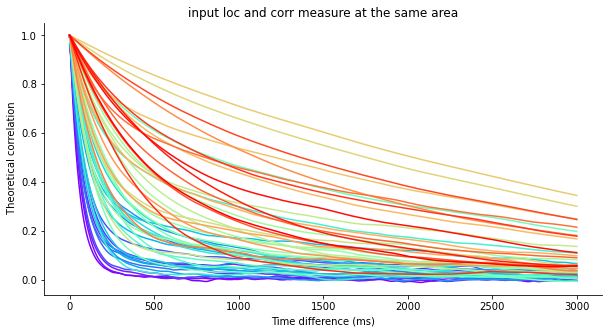

In [16]:
import matplotlib.cm as cm
clist = cm.get_cmap(plt.get_cmap('rainbow'))(np.linspace(0.0, 1.0, p['n_area']))[np.newaxis, :, :3]

plt.figure(figsize=(10,5), facecolor=(1, 1, 1))
ax = plt.axes()
for i in np.arange(p['n_area']):
    plt.plot(np.arange(T_lag+1),np.real(acf_data[i,:]),color=clist[0][i])

# plt.legend(area_name_list)
plt.xlabel('Time difference (ms)')
plt.ylabel(' Theoretical correlation')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('input loc and corr measure at the same area')
# TCP.save_fig('Figures/3B_a')

## Theoretical ACF

Initializing Model. From subgraph_data_marmoset.pkl load:
dict_keys(['fln_mat', 'sln_mat', 'hier_vals', 'areas'])
CONSENSUS_CASE=0
No STRONG GBA
inv_cond= 295.75782451607154
Start exp fitting!


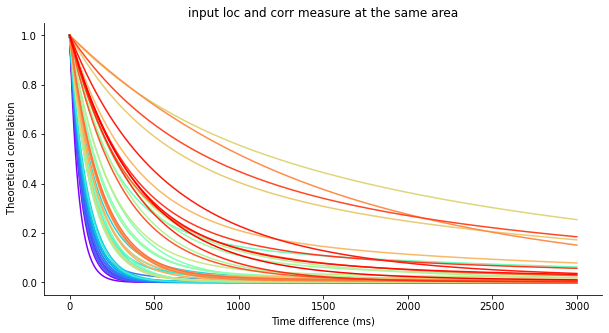

In [22]:
p = pf.load_data(datafile)
p,W = pf.genetate_net_connectivity(p,LINEAR_HIER=0,IDENTICAL_HIER=0,FIT_HIER=1, LOCAL_IDENTICAL_HIERARCHY=0,ZERO_FLN=0,IDENTICAL_FLN=0,
                                   SHUFFLE_FLN=0,SHUFFLE_TYPE=0,STRONG_GBA=0,MACAQUE_CASE=MACAQUE_CASE,
                                   GATING_PATHWAY=0,LONGRANGE_EI_ASYMMETRY=0,CONSENSUS_CASE=CONSENSUS_CASE,
                                   diverse_hi=4)

W_EI_ori = tc.generate_W_EI_shuffle_fln(p.copy(), p['fln_mat'].copy())
eigVals_ori, eigVecs_ori = np.linalg.eig(W_EI_ori)
    
coef_ori, delay_time_ori, acf_data_ori, tau_s_ori = tc.theoretical_time_constant_input_at_all_areas(p.copy(), eigVecs_ori,eigVals_ori, int(3e3), 1)
TCP.save_fig('Figures/3B_b')

# Fig. 3C Recovered timescale from ACF 

In [14]:
data_resting_simu = np.load('Data/Marmoset_Model/r_exc_full.npy')
df_Model = pd.read_excel('Data/Marmoset_Model/Area_map_Marmoset_W.xlsx')
tau_lst_simu, fok_lst_simu = TCP.compute_time_constant(data_resting_simu.T, df_Model['Area'], df_Model['Area'])

In [15]:
[m, n] = np.shape(data_resting_simu)
data_length = m / 1000 # Seconds
print(data_length)

2000.001


## Scatter Plot

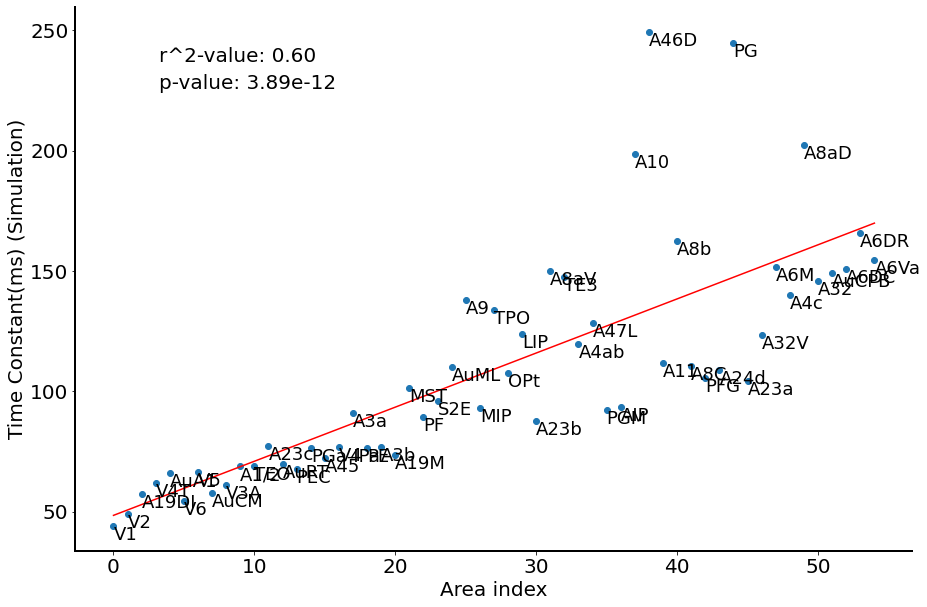

In [16]:
fig = TCP.plot_tau_feature(tau_lst_simu, np.arange(len(tau_lst_simu)), df_Model['Area'],
        x_label='Area index', y_label='Time Constant(ms) (Simulation)',
        annotate_flag=True, log_flag=False)
# plt.ylim([10, 50])
# TCP.save_fig('Figures/3C_a')

## Barplot

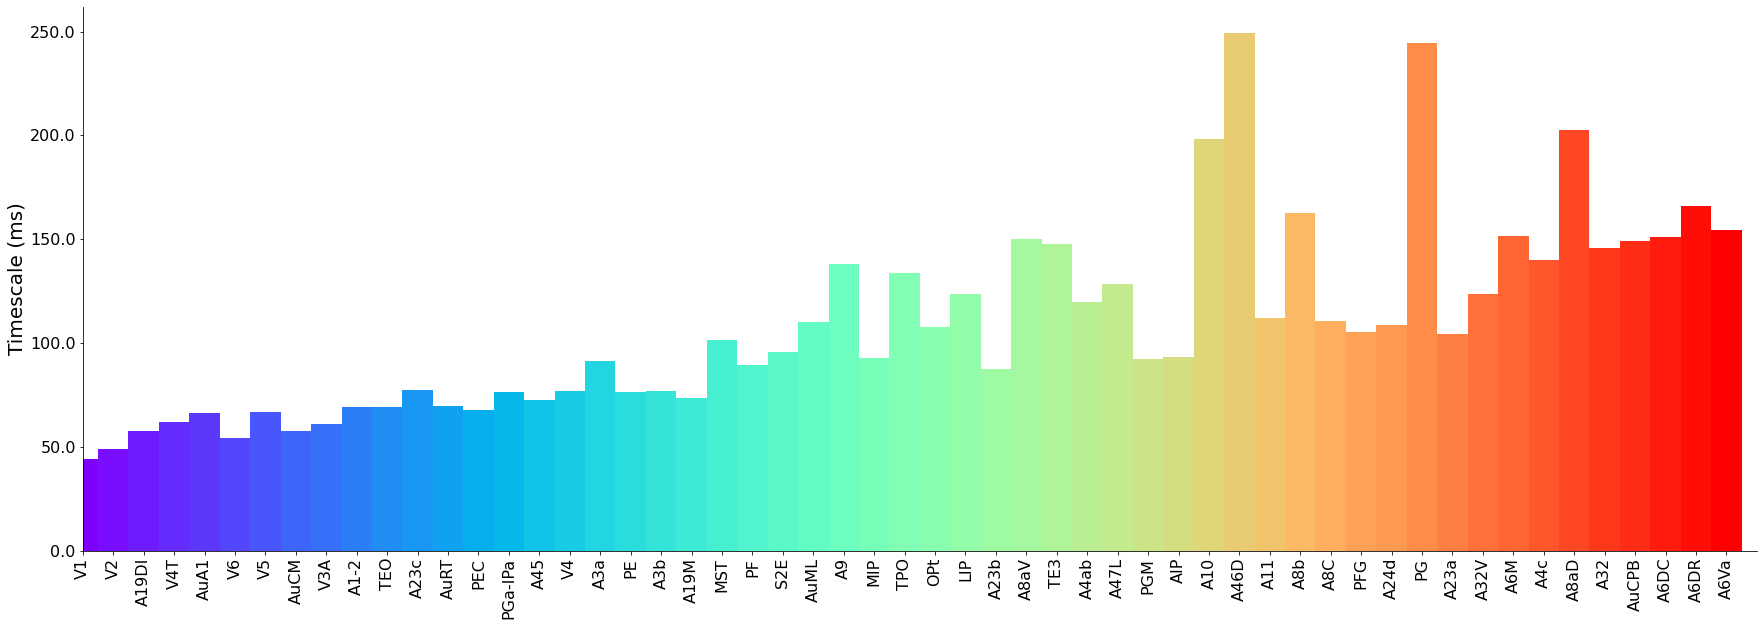

In [17]:
fig, ax=plt.subplots(figsize=(30,10), facecolor=(1, 1, 1))
clist = cm.get_cmap(plt.get_cmap('rainbow'))(np.linspace(0.0, 1.0, p['n_area']))[np.newaxis, :, :3]
ax.bar(np.arange(len(p['areas'])), tau_lst_simu,width = 1,color=clist[0])
ax.set_xticks(np.arange(len(p['areas'])))
ax.set_yticks(np.linspace(0, 250, 6))
ax.set_yticklabels(np.linspace(0, 250, 6),fontsize=16)
ax.set_xticklabels(p['areas'],rotation=90,fontsize=16)
# plt.yticks([10,100,1000],['10 ms','100 ms','1 s'],rotation=0)
ax.set_ylabel('Timescale (ms)',fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim((0, p['n_area']))
TCP.save_fig('Figures/3C_b')

Running network with stimulation to V1   PULSE_INPUT=1   MACAQUE_CASE=0


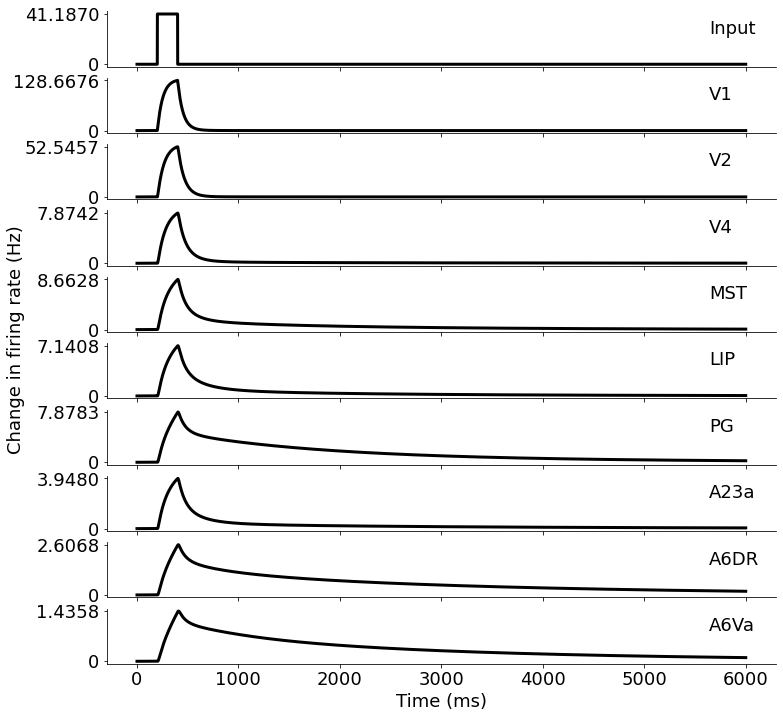

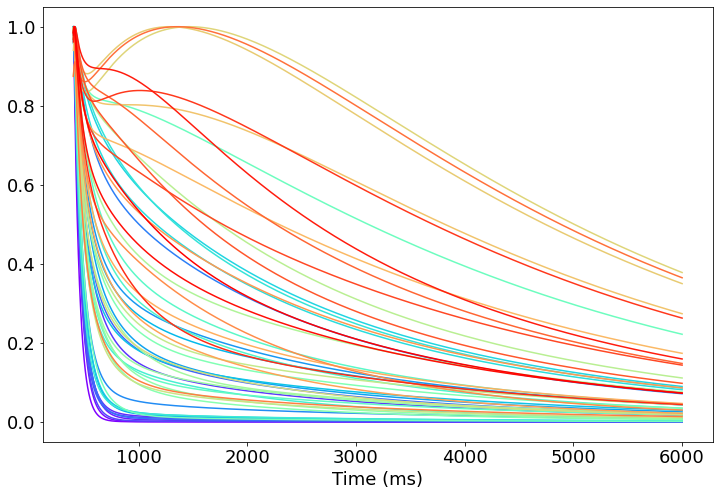

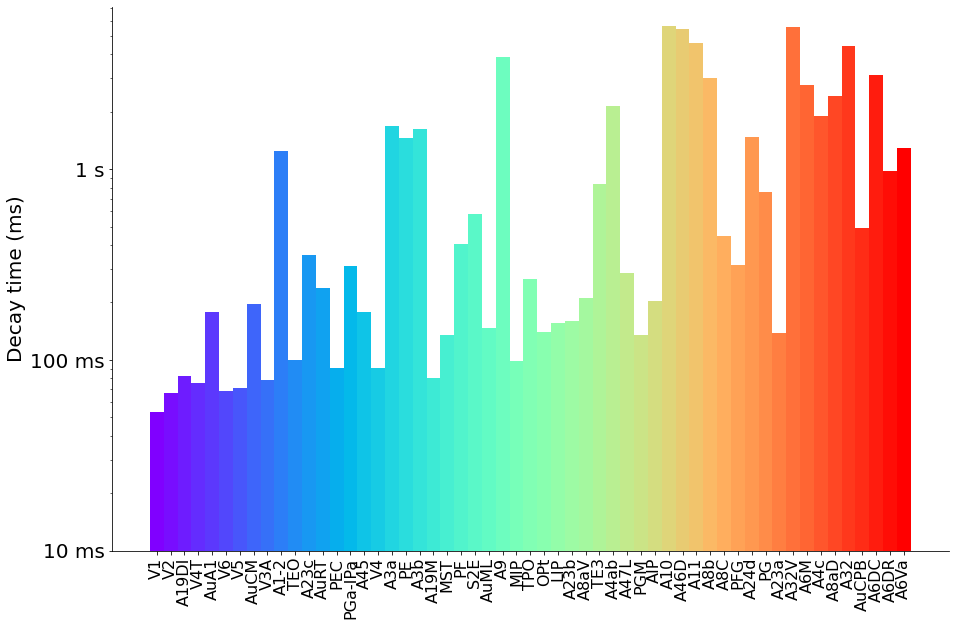

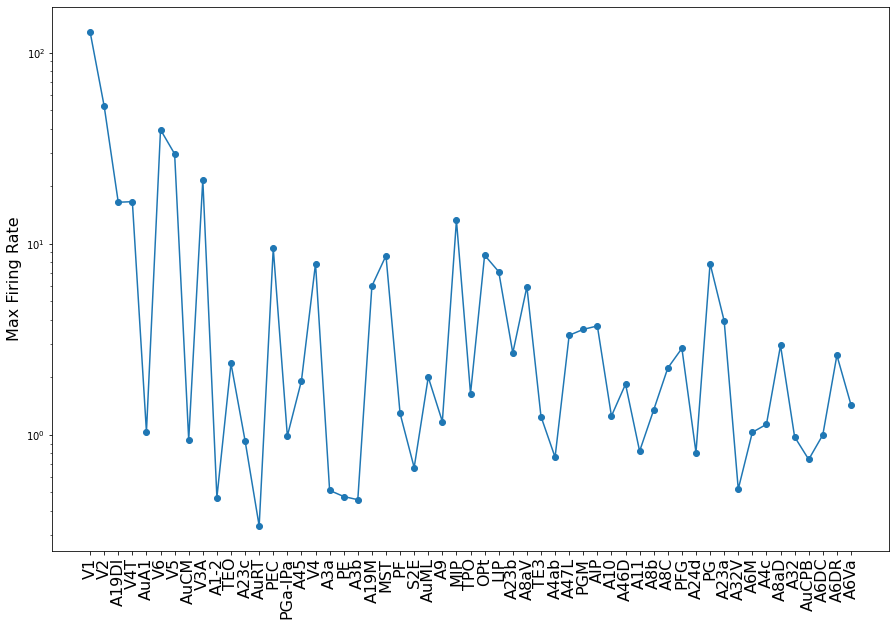

In [19]:
# Timescale after V1 stimulus
I_stim_exc, r_exc, r_inh, area_stim_idx, dt, t_plot, decay_time, max_rate, f \
 = pf.run_stimulus(p, VISUAL_INPUT=1, TOTAL_INPUT=0, T=6000, PULSE_INPUT=1,
                    MACAQUE_CASE=MACAQUE_CASE ,GATING_PATHWAY=0, CONSENSUS_CASE=0)

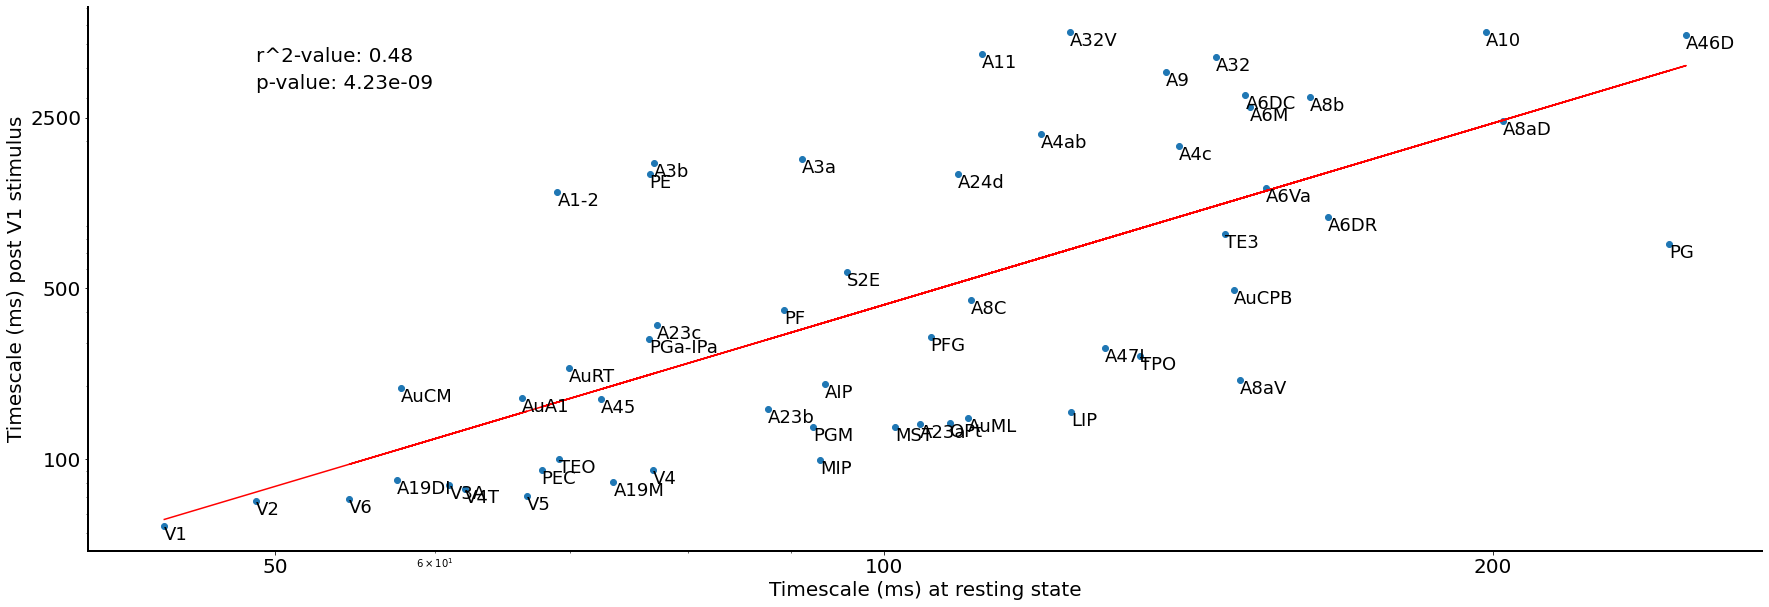

In [34]:
fig = TCP.plot_tau_feature(decay_time, tau_lst_simu, p['areas'],
        x_label='Timescale (ms) at resting state', y_label='Timescale (ms) post V1 stimulus',
        annotate_flag=True, log_flag=True, loglog_flag=True)
# plt.xscale('log')
fig.set_figwidth(30)
plt.xticks([50, 100, 200], ['50', '100', '200'])
plt.yticks([100, 500, 2500], ['100', '500', '2500'])
TCP.save_fig('Figures/3_tau_compare')

## Comparison of model timescale with experimental data.

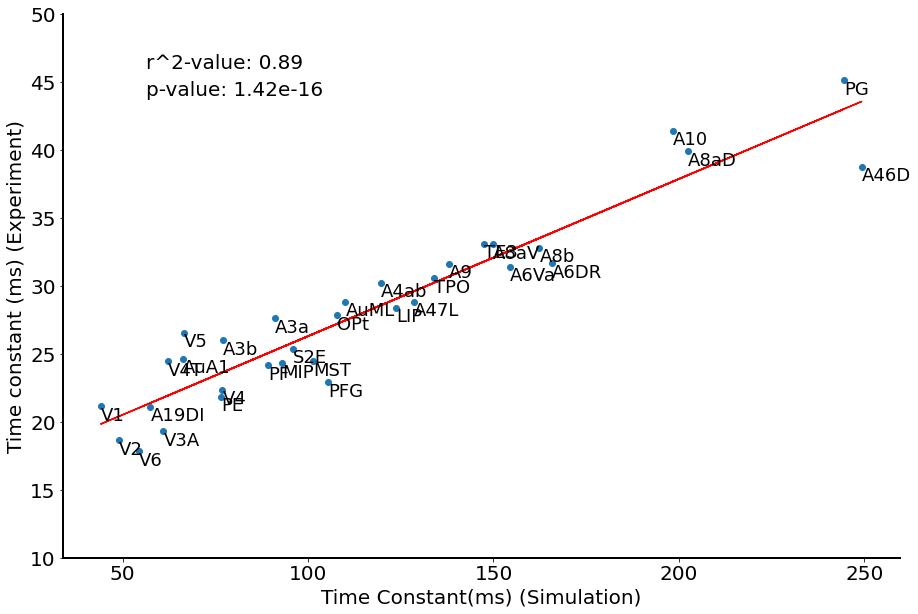

In [29]:
data_resting_simu = np.load('Data/Marmoset_Model/r_exc_full.npy')
df_Model = pd.read_excel('Data/Marmoset_Model/Area_map_Marmoset_W.xlsx')
tau_lst_simu, fok_lst_simu = TCP.compute_time_constant(data_resting_simu.T, df_Model['Area'], area)
# tau_lst_exp, fok_lst_exp = TCP.compute_time_constant(channel_eff, Area, area)
fig = TCP.plot_tau_feature(tau_lst_exp, tau_lst_simu, area,
        x_label='Time Constant(ms) (Simulation)', y_label='Time constant (ms) (Experiment)',
        annotate_flag=True, log_flag=False)
plt.ylim([10, 50])
TCP.save_fig('Figures/3C_c')

# Fig. 3D Comparison of model timescale with Spine count.

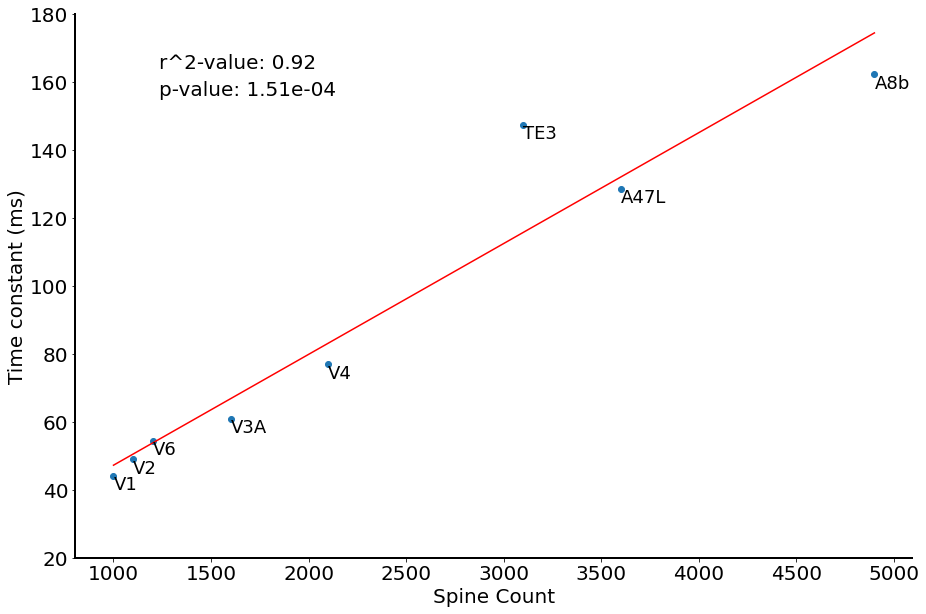

In [34]:
# Plots for AOI
tau_AOI = [0]*len(AOI)
for i in range(len(AOI)):
    tau_AOI[i] = tau_lst_simu[list(area).index(AOI[i])]
    
fig7 = TCP.plot_tau_feature(tau_AOI, spine_count_AOI, AOI,
        x_label='Spine Count', y_label='Time constant (ms)',
        annotate_flag=True, log_flag=False)
plt.ylim([20, 180])

TCP.save_fig('Figures/3D')